## Introduction
The goal of this exercise is to build a credit risk model to minimize the approval of bad loan applications. The dataset used in this notebook contains historical data about loan applications. The 'target' variable contains 3 values: '1' for loans that were charged-off, '0' for loans that closed in good standing and 'NaN' for loan applications that were declined. 

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
np.random.seed(44)

## Loading the data

In [3]:
data = pd.read_csv('candidate_ds_build.csv')

In [4]:
data.head(10)

,loan_id,customer_id,loan_term_months,monthly_income,credit_score,monthly_debt,apr,channel,approved,line,...,htx1878,sgf1468,brv6621,wio6906,hoj1062,qyr7516,woq6396,zlv8072,rdr0779,target
0,750001,349053,48,16300.0,753,6345.715811,0.06772,Indirect,True,2900.0,...,83557,7521894,1359730,125,25648,8334667,63.0,7666946,8955865,0.0
1,750002,787676,36,9500.0,653,3160.804515,0.18336,Direct,True,6900.0,...,84704,7834976,1322548,182,21220,9110630,56.0,8082449,2536656,0.0
2,750003,147629,36,2900.0,739,1122.729321,0.12554,Direct,True,3700.0,...,79867,8030414,2305651,201,31907,8921639,56.0,8113848,5280201,0.0
3,750004,103024,24,2000.0,652,1185.145868,0.18336,Direct,True,6200.0,...,83874,8143904,1883813,178,20863,8757772,55.0,7996149,4701734,0.0
4,750005,439985,24,4700.0,601,2089.888424,0.18336,Direct,True,6400.0,...,83838,7905531,1503813,185,23761,9245806,60.0,7876602,9693850,0.0
5,750006,786417,36,1400.0,587,1055.840831,0.18336,Indirect,False,0.0,...,99997,9999993,9999994,993,99995,9999994,NaN,1,8063569,NaN
6,750007,727280,24,8000.0,720,3723.926069,0.12554,Direct,True,4600.0,...,82430,8232684,1715823,173,23319,8984787,65.0,7629960,271237,0.0
7,750008,521143,36,5200.0,810,0.000000,0.06772,Direct,False,0.0,...,92280,9280972,2653595,81,19846,8068471,64.0,8284841,3371327,NaN
8,750009,450392,36,800.0,782,378.723442,0.06772,Direct,False,0.0,...,83135,8664564,2046288,147,27037,9145237,59.0,8591456,9371521,NaN
9,750010,133138,36,600.0,629,134.003811,0.18336,Indirect,False,0.0,...,86836,7811630,1019086,219,22925,9145459,57.0,7279991,4233774,NaN


## Analysing the differences in profile details of 'approved' and 'declined' loan applications.



> Separating the 'approved' and 'declined' loan applications into 2 separate dataframes for convenience.



In [5]:
data_approved = pd.DataFrame(data[data['target'].notnull()])

In [6]:
data_declined = pd.DataFrame(data[data['target'].isnull()])

In [7]:
x = PrettyTable()

x.field_names = ["Statistics", "Approved Applicant", "Declined Applicant"]

x.add_row(["Count of Applications", data_approved.shape[0], data_declined.shape[0]])
x.add_row(["Average Credit Score", data_approved['credit_score'].mean(), data_declined['credit_score'].mean()])
x.add_row(["Average Monthly Income", data_approved['monthly_income'].mean(), data_declined['monthly_income'].mean()])
x.add_row(["Average Approved Line", data_approved[(data_approved['approved'] == True)]['line'].mean(), data_declined[(data_declined['approved'] == True)]['line'].mean()])
x.add_row(["Average Monthly Debt", data_approved['monthly_debt'].mean(), data_declined['monthly_debt'].mean()])
x.add_row(["Average Debt-to-income ratio (DTI)", (data_approved['monthly_debt']/data_approved['monthly_income']).mean(), (data_declined['monthly_debt']/data_declined['monthly_income']).mean()])
x.add_row(["Average Number of inquiries", data_approved['number_of_inquiries'].mean(), data_declined['number_of_inquiries'].mean()])
x.add_row(["Average Months on file", data_approved['months_on_file'].mean(), data_declined['months_on_file'].mean()])
x.add_row(["Average Number of trades", data_approved['number_of_trades'].mean(), data_declined['number_of_trades'].mean()])

print(x)

+------------------------------------+--------------------+--------------------+
|             Statistics             | Approved Applicant | Declined Applicant |
+------------------------------------+--------------------+--------------------+
|       Count of Applications        |       35829        |       14171        |
|        Average Credit Score        | 703.8580479499847  |  618.313668760144  |
|       Average Monthly Income       | 5458.380083172849  | 3488.5964293274997 |
|       Average Approved Line        | 4431.828965363253  |        nan         |
|        Average Monthly Debt        | 1944.5407946147402 | 2150.3357439578003 |
| Average Debt-to-income ratio (DTI) | 0.353657999342815  | 0.5470353048216571 |
|    Average Number of inquiries     | 0.8388177174914175 | 1.671582809964011  |
|       Average Months on file       | 64.41600379580787  | 52.019405828805304 |
|      Average Number of trades      | 3.714616651315973  | 1.9283042833956672 |
+---------------------------

* The count of approved loan applications is more than twice the count of declined loan applications.
* The loan applications of people with average monthly income of around $5000 are less likely to get declined.
* A credit score of higher than 700 is more likely to get a loan application approved, thus considered a good credit score.
* Approved applicants tend to have about twice the number of trades as that of the declined applications.





## Analysing the loan accounts based on their credit scores.



> First, binning the 'credit_score' field into buckets of '<600', '600-699', '700-799' and '800+'.



In [8]:
bins = [0, 599, 699, 799, 1000]
buckets =['<600','600-699','700-799','800+']
data['credit_score_bucket'] = pd.cut(data['credit_score'], bins, labels=buckets)
data[['credit_score', 'credit_score_bucket']]

,credit_score,credit_score_bucket
0,753,700-799
1,653,600-699
2,739,700-799
3,652,600-699
4,601,600-699
...,...,...
49995,710,700-799
49996,660,600-699
49997,791,700-799
49998,850,800+


In [9]:
y = PrettyTable()

y.field_names = ["Statistics", "Credit score <600", "Credit score 600-699", "Credit score 700-799", "Credit score 800+"]

y.add_row(["Average Credit Score", data[data['credit_score_bucket']=='<600']['credit_score'].mean(), data[data['credit_score_bucket']=='600-699']['credit_score'].mean(), data[data['credit_score_bucket']=='700-799']['credit_score'].mean(), data[data['credit_score_bucket']=='800+']['credit_score'].mean()])
y.add_row(["Bad Rate", (len(data[(data['credit_score_bucket']=='<600') & (data['target']==1.0)]) / len(data[data['credit_score_bucket']=='<600'])) * 100, (len(data[(data['credit_score_bucket']=='600-699') & (data['target']==1.0)]) / len(data[data['credit_score_bucket']=='600-699'])) * 100, (len(data[(data['credit_score_bucket']=='700-799') & (data['target']==1.0)]) / len(data[data['credit_score_bucket']=='700-799'])) * 100, (len(data[(data['credit_score_bucket']=='800+') & (data['target']==1.0)]) / len(data[data['credit_score_bucket']=='800+'])) * 100])
y.add_row(["Count of Applications", len(data[(data['credit_score_bucket']=='<600')]), len(data[(data['credit_score_bucket']=='600-699')]), len(data[(data['credit_score_bucket']=='700-799')]), len(data[(data['credit_score_bucket']=='800+')])])
y.add_row(["Count of Approvals", len(data[(data['credit_score_bucket']=='<600') & data['approved']==True]), len(data[(data['credit_score_bucket']=='600-699') & data['approved']==True]), len(data[(data['credit_score_bucket']=='700-799') & data['approved']==True]), len(data[(data['credit_score_bucket']=='800+') & data['approved']==True])])
y.add_row(["Average Monthly Income", data[data['credit_score_bucket']=='<600']['monthly_income'].mean(), data[data['credit_score_bucket']=='600-699']['monthly_income'].mean(), data[data['credit_score_bucket']=='700-799']['monthly_income'].mean(), data[data['credit_score_bucket']=='800+']['monthly_income'].mean()])
y.add_row(["Approval rate", (len(data[(data['credit_score_bucket']=='<600') & (data['approved']==True)]) / len(data[data['credit_score_bucket']=='<600'])) * 100, (len(data[(data['credit_score_bucket']=='600-699') & (data['approved']==True)]) / len(data[data['credit_score_bucket']=='600-699'])) * 100, (len(data[(data['credit_score_bucket']=='700-799') & (data['approved']==True)]) / len(data[data['credit_score_bucket']=='700-799'])) * 100, (len(data[(data['credit_score_bucket']=='800+') & (data['approved']==True)]) / len(data[data['credit_score_bucket']=='800+'])) * 100])
y.add_row(["Average Approved Line", data[(data['credit_score_bucket']=='<600') & (data['approved']==True)]['line'].mean(), data[(data['credit_score_bucket']=='600-699') & (data['approved']==True)]['line'].mean(), data[(data['credit_score_bucket']=='700-799') & (data['approved']==True)]['line'].mean(), data[(data['credit_score_bucket']=='800+') & (data['approved']==True)]['line'].mean()])
y.add_row(["Average Monthly Debt", data[data['credit_score_bucket']=='<600']['monthly_debt'].mean(), data[data['credit_score_bucket']=='600-699']['monthly_debt'].mean(), data[data['credit_score_bucket']=='700-799']['monthly_debt'].mean(), data[data['credit_score_bucket']=='800+']['monthly_debt'].mean()])
y.add_row(["Average Debt-to-income ratio (DTI)", (data[data['credit_score_bucket']=='<600']['monthly_debt'] / data[data['credit_score_bucket']=='<600']['monthly_income']).mean(), (data[data['credit_score_bucket']=='600-699']['monthly_debt'] / data[data['credit_score_bucket']=='600-699']['monthly_income']).mean(), (data[data['credit_score_bucket']=='700-799']['monthly_debt'] / data[data['credit_score_bucket']=='700-799']['monthly_income']).mean(), (data[data['credit_score_bucket']=='800+']['monthly_debt'] / data[data['credit_score_bucket']=='800+']['monthly_income']).mean()])
y.add_row(["Average Number of inquiries", data[data['credit_score_bucket']=='<600']['number_of_inquiries'].mean(), data[data['credit_score_bucket']=='600-699']['number_of_inquiries'].mean(), data[data['credit_score_bucket']=='700-799']['number_of_inquiries'].mean(), data[data['credit_score_bucket']=='800+']['number_of_inquiries'].mean()])
y.add_row(["Average Months on file", data[data['credit_score_bucket']=='<600']['months_on_file'].mean(), data[data['credit_score_bucket']=='600-699']['months_on_file'].mean(), data[data['credit_score_bucket']=='700-799']['months_on_file'].mean(), data[data['credit_score_bucket']=='800+']['months_on_file'].mean()])
y.add_row(["Average Number of trades", data[data['credit_score_bucket']=='<600']['number_of_trades'].mean(), data[data['credit_score_bucket']=='600-699']['number_of_trades'].mean(), data[data['credit_score_bucket']=='700-799']['number_of_trades'].mean(), data[data['credit_score_bucket']=='800+']['number_of_trades'].mean()])

print(y)

+------------------------------------+--------------------+----------------------+----------------------+---------------------+
|             Statistics             | Credit score <600  | Credit score 600-699 | Credit score 700-799 |  Credit score 800+  |
+------------------------------------+--------------------+----------------------+----------------------+---------------------+
|        Average Credit Score        | 557.7979307702133  |  653.1096463314847   |  741.2022565816966   |  827.1969608416131  |
|              Bad Rate              |        0.0         |  9.709973633966724   |  3.2415975165661757  |  1.081239041496201  |
|       Count of Applications        |        7829        |        21998         |        16751         |         3422        |
|         Count of Approvals         |         0          |        18155         |        14617         |         3057        |
|       Average Monthly Income       | 4907.4849916975345 |  4936.657877988908   |  4875.094024237359   

*   Loan applications with credit score less than 600 are usually declined.
*   The higher the credit score, the higher the approval rate of loan applications.  
*   The higher the credit score, the lower the chances of the account being 'charged-off'.
*   The higher the credit score, the lower is the debt-to-income ratio of the applicant.
*   Monthly income of an applicant does not imapct the credit score of the applicant.
*   The higher the credit score, the longer the period of time for the account to be on file.



## Analysing the loan accounts based on the 'Channel' field from the available data.


> To calculate the statistics based on the 'channel' column, first checking the different values of channels available in the data. There are 2 distinct channels: 'Direct' and 'Indirect'.



In [10]:
data['channel'].value_counts()

Direct      37448
Indirect    12552
Name: channel, dtype: int64

In [11]:
z = PrettyTable()

z.field_names = ["Statistics", "Channel: Direct", "Channel: Indirect"]

z.add_row(["Bad Rate", (len(data[(data['channel']=="Direct") & (data['target']==1.0)]) / len(data[(data['channel']=="Direct")])) * 100, (len(data[(data['channel']=="Indirect") & (data['target']==1.0)]) / len(data[(data['channel']=="Indirect")])) * 100])
z.add_row(["Average Credit Score", data[data['channel']=="Direct"]['credit_score'].mean(), data[data['channel']=="Indirect"]['credit_score'].mean()])
z.add_row(["Count of Applications", len(data[data['channel']=="Direct"]), len(data[data['channel']=="Indirect"])])
z.add_row(["Count of Approvals", len(data[(data['channel']=="Direct") & (data['approved']==True)]), len(data[(data['channel']=="Indirect") & (data['approved']==True)])])
z.add_row(["Average Monthly Income", data[data['channel']=="Direct"]['monthly_income'].mean(), data[data['channel']=="Indirect"]['monthly_income'].mean()])
z.add_row(["Approval Rate", (len(data[(data['channel']=="Direct") & (data['approved']==True)]) / len(data[data['channel']=="Direct"])) * 100, (len(data[(data['channel']=="Indirect") & (data['approved']==True)]) / len(data[data['channel']=="Indirect"])) * 100])
z.add_row(["Average Approved Line", data[(data['channel']=="Direct") & (data['approved']==True)]['line'].mean(), data[(data['channel']=="Indirect") & (data['approved']==True)]['line'].mean()])
z.add_row(["Average Monthly Debt", data[data['channel']=="Direct"]['monthly_debt'].mean(), data[data['channel']=="Indirect"]['monthly_debt'].mean()])
z.add_row(["Average Debt-to-income ratio (DTI)", (data[data['channel']=="Direct"]['monthly_debt']/data[data['channel']=="Direct"]['monthly_income']).mean(), (data[data['channel']=="Indirect"]['monthly_debt']/data[data['channel']=="Indirect"]['monthly_income']).mean()])
z.add_row(["Average Number of inquiries", data[data['channel']=="Direct"]['number_of_inquiries'].mean(), data[data['channel']=="Indirect"]['number_of_inquiries'].mean()])
z.add_row(["Average Months on file", data[data['channel']=="Direct"]['months_on_file'].mean(), data[data['channel']=="Indirect"]['months_on_file'].mean()])
z.add_row(["Average Number of trades", data[data['channel']=="Direct"]['number_of_trades'].mean(), data[data['channel']=="Indirect"]['number_of_trades'].mean()])

print(z)

+------------------------------------+---------------------+--------------------+
|             Statistics             |   Channel: Direct   | Channel: Indirect  |
+------------------------------------+---------------------+--------------------+
|              Bad Rate              |  4.2619098483230085 | 8.922880815806247  |
|        Average Credit Score        |  679.6083903012177  | 679.6269917144679  |
|       Count of Applications        |        37448        |       12552        |
|         Count of Approvals         |        26801        |        9028        |
|       Average Monthly Income       |  4902.7424695577865 | 4892.232313575526  |
|           Approval Rate            |  71.56857509079256  | 71.92479286169535  |
|       Average Approved Line        |  4432.282377523226  | 4430.482941958352  |
|        Average Monthly Debt        |  2011.6795680517594 | 1976.5761228071299 |
| Average Debt-to-income ratio (DTI) | 0.40881755107110695 | 0.4074131700582128 |
|    Average Num

*   'Channel' is not being used in the approve/decline step as the approval rates for both cases are almost equal.
*   According to the data, 'channel' can be used to make the approve/decline decision because the 'bad rate' in case of 'Indirect' channel is more than twice of that in 'Direct' channel.




## Building a machine learning model to determine the risk of charge-off for a loan applicant.



> Loading the data again into a separate dataframe.


In [12]:
loan_data = pd.read_csv('candidate_ds_build.csv')

In [13]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_id              50000 non-null  int64  
 1   customer_id          50000 non-null  int64  
 2   loan_term_months     50000 non-null  int64  
 3   monthly_income       50000 non-null  float64
 4   credit_score         50000 non-null  int64  
 5   monthly_debt         50000 non-null  float64
 6   apr                  50000 non-null  float64
 7   channel              50000 non-null  object 
 8   approved             50000 non-null  bool   
 9   line                 50000 non-null  float64
 10  number_of_inquiries  50000 non-null  int64  
 11  months_on_file       50000 non-null  int64  
 12  number_of_trades     50000 non-null  int64  
 13  woq6395              50000 non-null  int64  
 14  zlv8071              50000 non-null  int64  
 15  rdr0778              50000 non-null 

## Exploratory data analysis

**- Missing values.**

> First, checking for null or missing values in the dataframe. Using seaborn library to plot a heatmap in order to visualize the missing values in each field.





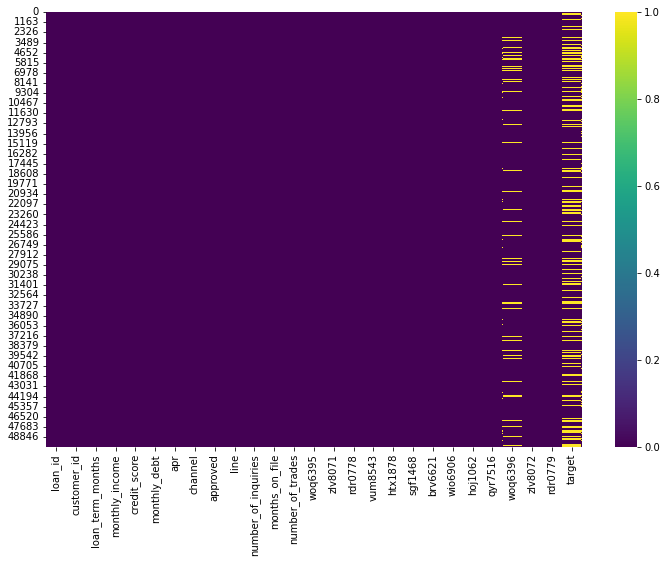

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(loan_data.isnull(), cmap='viridis')

> Dropping columns 'loan_id' and 'customer_id' since those information are not important in deciding risk factor of a loan. Also, dropping the column 'woq6396' since it contains null values and the column name does not make sense at the moment.



In [15]:
loan_data.drop(columns=['loan_id', 'customer_id', 'woq6396'], inplace=True)

> Now only 'target' column contains missing values which represent the 'declined loan applications'. Since the declined loan applications does not have performance data, it is not helpful in determining risk of charge-off. These records can be dropped from the dataframe. 

In [16]:
loan_data = loan_data.dropna()

**- Categorical columns** 
> Converting the categorical and boolean columns into numerical values.



In [17]:
loan_data['channel'] = pd.factorize(loan_data['channel'])[0]
loan_data['approved'] = pd.factorize(loan_data['approved'])[0]

> Checking the data types of the resulting columns to make sure they are all numerical.


In [18]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35829 entries, 0 to 49998
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_term_months     35829 non-null  int64  
 1   monthly_income       35829 non-null  float64
 2   credit_score         35829 non-null  int64  
 3   monthly_debt         35829 non-null  float64
 4   apr                  35829 non-null  float64
 5   channel              35829 non-null  int64  
 6   approved             35829 non-null  int64  
 7   line                 35829 non-null  float64
 8   number_of_inquiries  35829 non-null  int64  
 9   months_on_file       35829 non-null  int64  
 10  number_of_trades     35829 non-null  int64  
 11  woq6395              35829 non-null  int64  
 12  zlv8071              35829 non-null  int64  
 13  rdr0778              35829 non-null  int64  
 14  vum8543              35829 non-null  int64  
 15  htx1878              35829 non-null 

**- Feature correlation.**
> Finding the correlation between the features and the target variable.



In [19]:
correlations = loan_data.corrwith(loan_data['target'])
correlations

loan_term_months       0.061819
monthly_income         0.008883
credit_score          -0.169040
monthly_debt           0.078607
apr                    0.157384
channel               -0.105809
approved                    NaN
line                   0.053224
number_of_inquiries    0.156729
months_on_file        -0.185376
number_of_trades      -0.050484
woq6395               -0.125645
zlv8071                0.174902
rdr0778               -0.169873
vum8543                0.131733
htx1878               -0.156657
sgf1468               -0.172986
brv6621               -0.095001
wio6906                0.182588
hoj1062                0.052415
qyr7516               -0.055838
zlv8072               -0.174902
rdr0779                0.001791
target                 1.000000
dtype: float64

> Visualizing the correlation between features using a Heatmap.

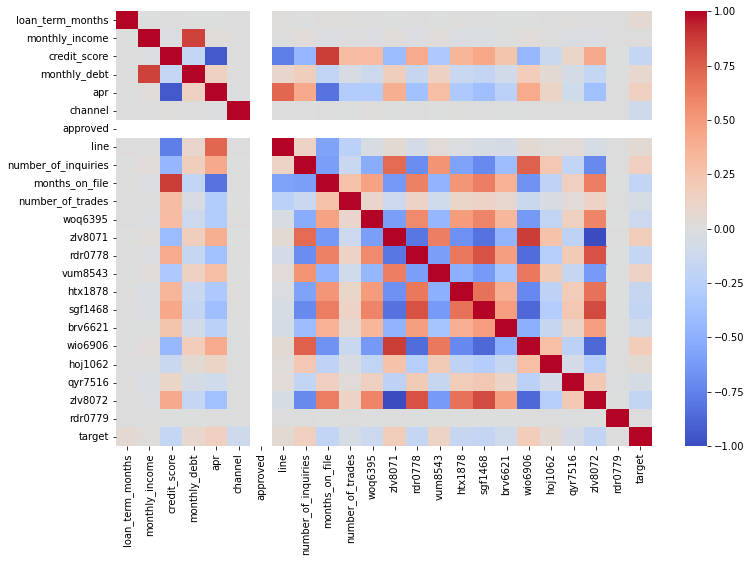

In [20]:
correlations = loan_data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlations, cmap="coolwarm")
plt.show()

> Dropping the 'approved' column since it is evident that the 'approved' field has no correlation with the target variable.

In [21]:
loan_data.drop(columns=['approved'], inplace=True)

> Plotting a histogram of the relation between 'credit_score' feature and the target variable.



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


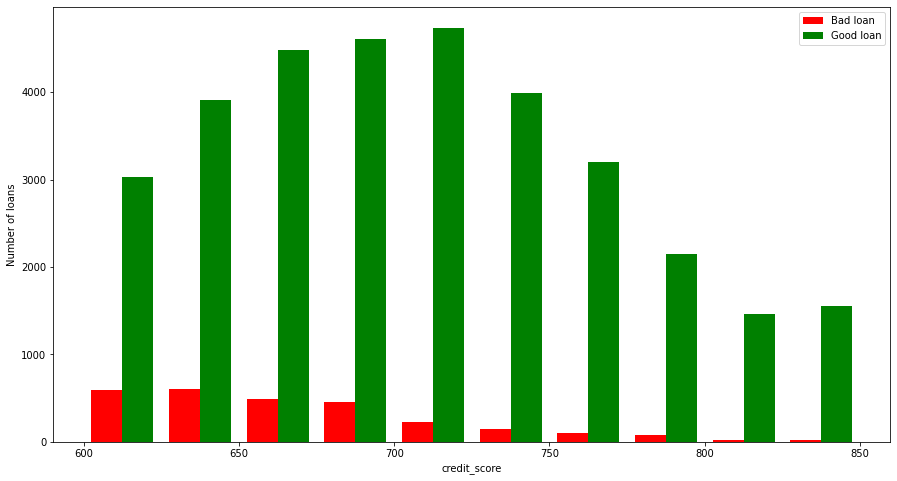

In [22]:
figure = plt.figure(figsize=(15, 8))
plt.hist([loan_data[loan_data['target'] == 1.0]['credit_score'], loan_data[loan_data['target'] == 0.0]['credit_score']], 
         stacked=False, color = ['r','g'],
         bins = 10, label = ['Bad loan','Good loan'])
plt.xlabel('credit_score')
plt.ylabel('Number of loans')
plt.legend()
plt.show()

**- Check data balance.** 

> Checking if the data is balanced in terms of the target variables. 



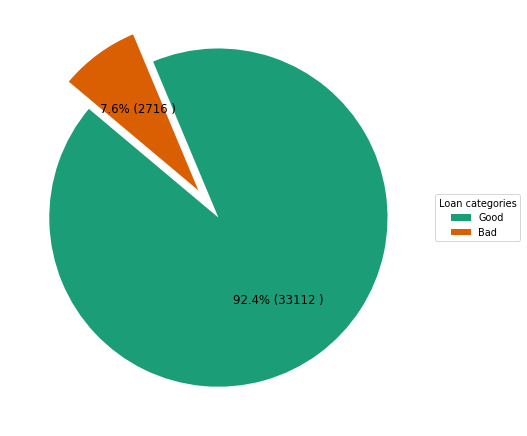

In [23]:
classes = loan_data['target'].value_counts()
index = ['Good','Bad']
classes.index = index

fig, ax = plt.subplots(figsize = (12, 8), subplot_kw = dict(aspect = "equal"), dpi = 70)

data = classes.values
categories = classes.index
explode = [0,0.2]

def diagram(percent, values):
    final = int(percent/100.*np.sum(values))
    return "{:.1f}% ({:d} )".format(percent, final)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct = lambda pct: diagram(pct, data),
                                  textprops = dict(color="black"), 
                                  colors = plt.cm.Dark2.colors,
                                  startangle = 140,
                                  explode = explode)

ax.legend(wedges, categories, title = "Loan categories", loc = "center left", bbox_to_anchor = (1, 0.5, 0, 0))
plt.setp(autotexts, size = 12, weight = 500)
plt.show()

## Imbalanced data handling

> Imbalanced data is not ideal for model performance. From the above finding, it is clear that the data is highly imbalanced with more than 90% of it belonging to one class and only 7.6% belonging to the other class.

Resampling can be performed in order to balance the data. There are 2 common ways:

*   **Undersampling** - Deletes samples from the majority class to balance with the minority class.
*   **Oversampling** - Duplicates samples in the minority class to balance with the majority class.

> Here, **SMOTE** methodology of oversampling is used to balance the data. 





* Splitting data into train and test sets





In [24]:
X = loan_data.drop('target', axis = 1)
y = loan_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [25]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print("Before resampling:\n", y_train.value_counts())
print("\nAfter resampling:\n", y_train_resampled.value_counts())

Before resampling:
 0.0    26515
1.0     2148
Name: target, dtype: int64

After resampling:
 0.0    26515
1.0    26515
Name: target, dtype: int64


## Feature Selection

It is not necessary that all features are equally responsible for the model outcome. Depending on the modeling technique, certain features are more important for the model performance. Feature selection is the process of selecting the features that prove more importance to the model.



* Training a Random Forest classifier on the resampled data



In [26]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = model_rf.predict(X_test)
train_pred_rf = model_rf.predict(X_train_resampled)



* Getting the model scores



In [35]:
training_accuracy_rf = accuracy_score(y_train_resampled, train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Training accuracy: {:.4}%".format(training_accuracy_rf * 100))
print("Test accuracy: {:.4}%".format(test_accuracy_rf * 100))
print("Precision score: %.2f" %precision_score(y_test, y_pred_rf))
print("Recall score: %.2f" %recall_score(y_test, y_pred_rf))
print("F1 Score: %.2f" % f1_score(y_test, y_pred_rf))
print(classification_report(y_test,y_pred_rf))

Training accuracy: 100.0%
Test accuracy: 90.5%
Precision score: 0.31
Recall score: 0.16
F1 Score: 0.21
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      6598
         1.0       0.31      0.16      0.21       568

    accuracy                           0.90      7166
   macro avg       0.62      0.56      0.58      7166
weighted avg       0.88      0.90      0.89      7166





* Visulaizing the importance score of each feature in the model decision



Text(0.5, 0, 'Feature Importance')

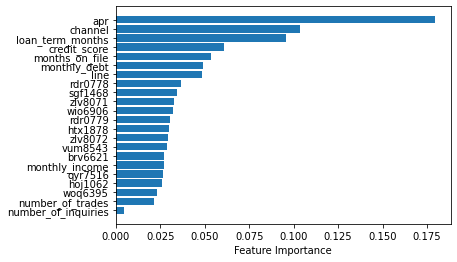

In [36]:
idx = model_rf.feature_importances_.argsort()
plt.barh(X_train_resampled.columns[idx], model_rf.feature_importances_[idx])
plt.xlabel("Feature Importance")


> As it is seen, the 'apr' is the most important feature, followed by 'channel', 'loan_term_months' and 'credit_score. The decision of how many and which features to keep, differs person to person. **Here, I have decided to keep all the features.**




## Model training

#### - XGBoost

In [37]:
model_xgb = XGBClassifier()

model_xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = model_xgb.predict(X_test)
train_pred_xgb = model_xgb.predict(X_train_resampled)

## Model Evaluation
Choosing metrics of model evaluation is crucial to the problem statement. Since this model will be used to determine the risk factor of a loan being 'charged-off', a measure of determining how many 'bad' loans the model can classify appropriately is important.

 * **The evaluation metrics chosen to evaluate the model are: Accuracy, Precision, Recall, F1-score and AUC score.**

 * **The main concern here is to avoid approving loans with risk of being 'charged-off', i.e, to avoid false negatives. Thus, amodel with higher recall score will be a better choice.**

In [38]:
training_accuracy_xgb = accuracy_score(y_train_resampled, train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("Training Accuracy: {:.4}%".format(training_accuracy_xgb * 100))
print("Test accuracy: {:.4}%".format(test_accuracy_xgb * 100))
print("Precision score: %.2f" %precision_score(y_test, y_pred_xgb))
print("Recall score: %.2f" %recall_score(y_test, y_pred_xgb))
print("F1 Score: %.2f" % f1_score(y_test, y_pred_xgb))
print(classification_report(y_test,y_pred_xgb))


Training Accuracy: 89.85%
Test accuracy: 87.97%
Precision score: 0.26
Recall score: 0.28
F1 Score: 0.27
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      6598
         1.0       0.26      0.28      0.27       568

    accuracy                           0.88      7166
   macro avg       0.60      0.60      0.60      7166
weighted avg       0.88      0.88      0.88      7166



#### XGBoost Feature importance

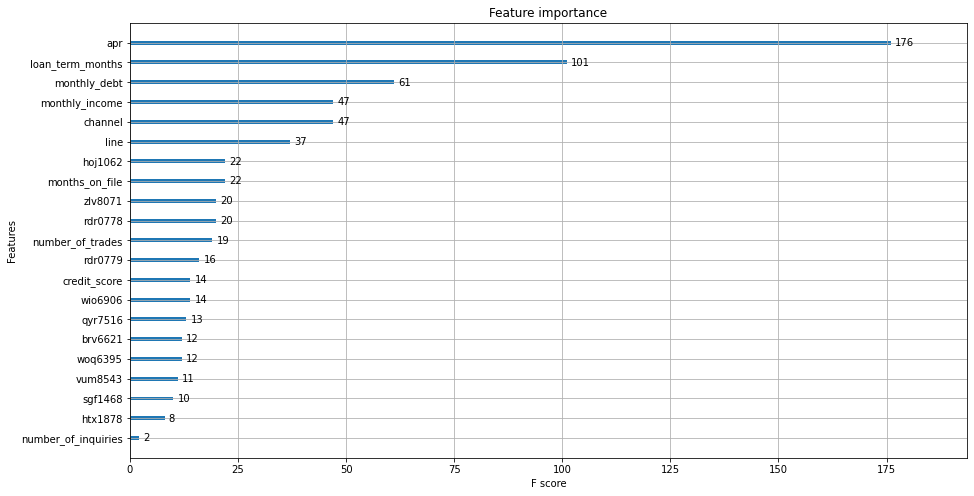

In [39]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (15, 8)
plot_importance(model_xgb)
plt.show()



> Plotting a confusion matrix to visualize the model scores for both the models



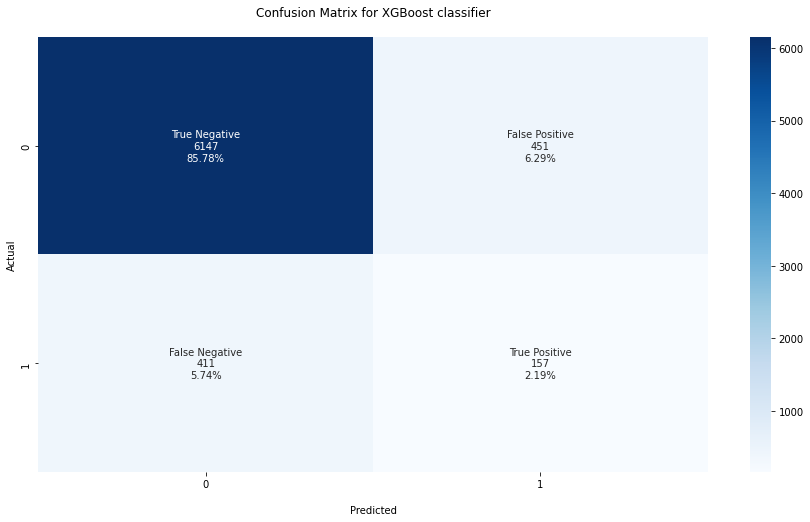

In [40]:
c_matrix = confusion_matrix(y_test, y_pred_xgb)

names = ['True Negative','False Positive','False Negative','True Positive']
counts = ["{0:0.0f}".format(value) for value in
                c_matrix.flatten()]
percentages = ["{0:.2%}".format(value) for value in
                     c_matrix.flatten()/np.sum(c_matrix)]

labels = [f"{x1}\n{x2}\n{x3}" for x1, x2, x3 in
          zip(names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for XGBoost classifier\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

plt.show()

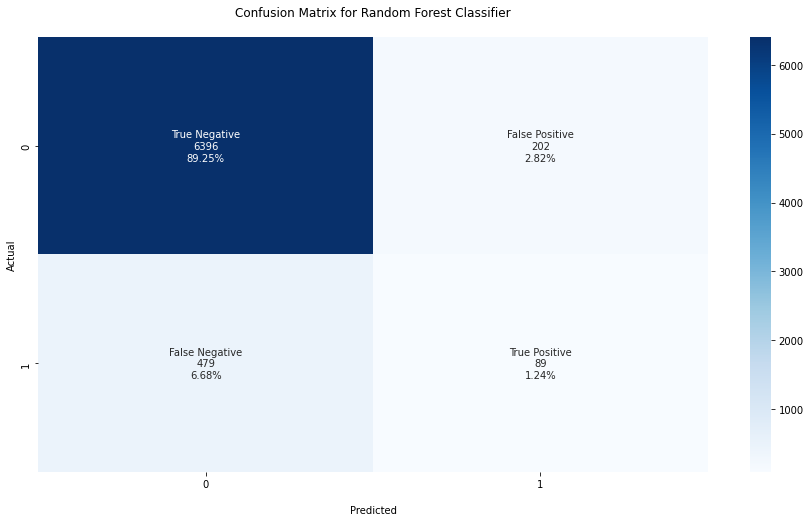

In [41]:
c_matrix_rf = confusion_matrix(y_test, y_pred_rf)

names = ['True Negative','False Positive','False Negative','True Positive']
counts = ["{0:0.0f}".format(value) for value in
                c_matrix_rf.flatten()]
percentages = ["{0:.2%}".format(value) for value in
                     c_matrix_rf.flatten()/np.sum(c_matrix_rf)]

labels = [f"{x1}\n{x2}\n{x3}" for x1, x2, x3 in
          zip(names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(c_matrix_rf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for Random Forest Classifier\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

plt.show()



> ROC curve for the two models



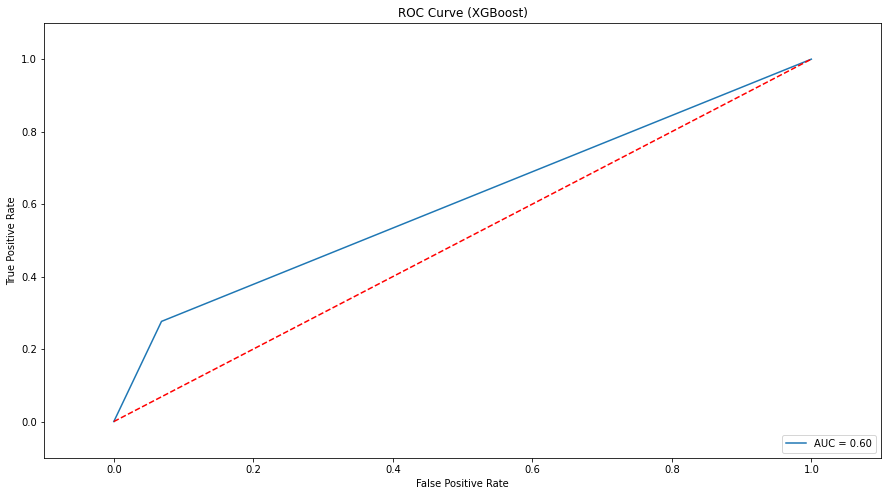

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb)

auc_score = auc(fpr, tpr)

plt.title('ROC Curve (XGBoost)')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

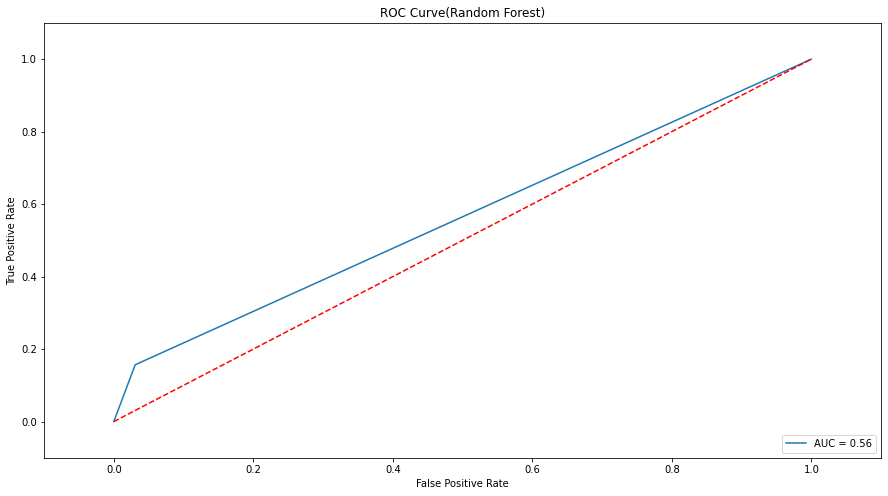

In [43]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)

auc_score = auc(fpr, tpr)

plt.title('ROC Curve(Random Forest)')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()



### Comparing model response graph for 'bad rate' with credit score vs 'bad rate' graph



* **Plotting the credit score vs bad rate graph**

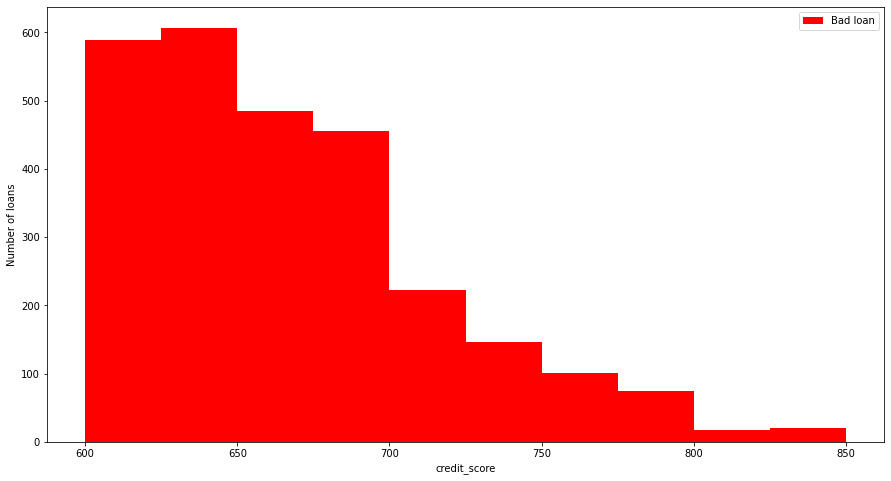

In [44]:
figure = plt.figure(figsize=(15, 8))
plt.hist([loan_data[loan_data['target'] == 1.0]['credit_score']], color = ['r'],
         bins = 10, label = ['Bad loan'])
plt.xlabel('credit_score')
plt.ylabel('Number of loans')
plt.legend()
plt.show()

* Installing modelplotpy module for the model response graph

In [45]:
pip install git+https://github.com/modelplot/modelplotpy.git

  Cloning https://github.com/modelplot/modelplotpy.git to /tmp/pip-req-build-8xz7fnhz
  Running command git clone -q https://github.com/modelplot/modelplotpy.git /tmp/pip-req-build-8xz7fnhz


* **Plotting the xgboost model score decile vs bad rate graph**

Default scope value no_comparison selected, single evaluation line will be plotted.
Target class 1, dataset test data and model xgboost.
The response plot is saved in /content/Response plot.png


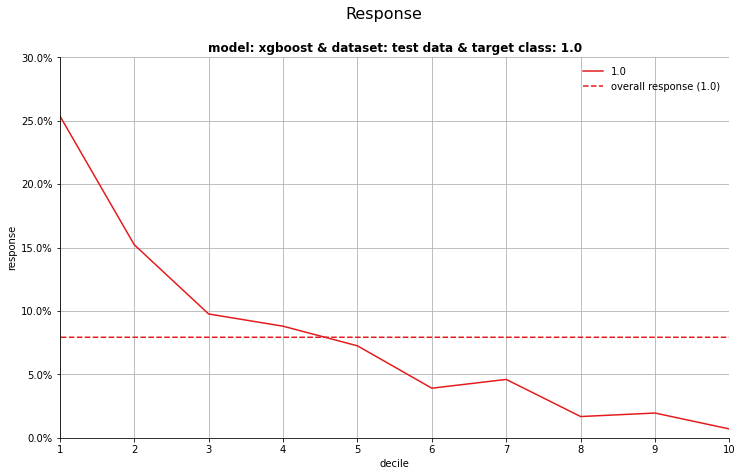

<Figure size 1080x576 with 0 Axes>

In [47]:
import modelplotpy as mp
obj = mp.modelplotpy(feature_data = [X_train_resampled, X_test], label_data = [y_train_resampled, y_test],
                     dataset_labels = ['train data', 'test data'], models = [model_xgb], model_labels = ['xgboost']
                     )

ps = obj.plotting_scope(select_model_label = ['xgboost'], select_dataset_label = ['test data'], select_targetclass=[1])

mp.plot_response(ps)



From the two graphs above, it is seen that the bad rate is higher in the first few deciles and decreases towards the later deciles, for both credit score and model score.



## Conclusion

* The XGBoost model gives better result with a higher recall score of 0.28 compared to recall score of 0.16 of the Random Forest model.

* AUC score of the XGBoost model (0.6) is higher than that of the Random Forest model (0.56).

* Thus, although the Random Forest model has a higher test accuracy score, the XGBoost model is the better model to determine the risk factor of loan application being 'charged-off'.